# クリーク被覆問題

こちらでは、[Lucas, 2014, "Ising formulations of many NP problems"](https://doi.org/10.3389/fphy.2014.00005)の 6.2. Clique Cover を OpenJij と [JijModeling](https://www.ref.documentation.jijzept.com/jijmodeling/)、そして[JijModeling transpiler](https://www.ref.documentation.jijzept.com/jijmodeling-transpiler/) を用いて解く方法をご紹介します。


## 概要: クリーク被覆問題

クリーク被覆問題は、あるグラフと整数nが与えられた時に、グラフをn個のクリーク（完全グラフ）に分割できるかを決定する問題です。

### 完全グラフ

完全グラフ(complete graph)とは、相異なる2点が全て隣接しているグラフ(ただしループや多重辺を含まない)構造のことです。具体的には以下のようなものを指します。

![](../../../assets/clique_cover_01.png)

完全グラフは、そこに含まれる2点を選んだときに、その2点が必ず辺で結ばれているような構造を持ちます。完全グラフの頂点数を$N$とすると、辺の数は$V$個の頂点から2つを選ぶ組合せの数${}_V C_2 = \frac{1}{2} V (V-1)$だけあることがわかります。  
完全グラフとの差が小さくなるように、最適化問題を定式化していきましょう。

### バイナリ変数

頂点$v$が$n$番目のクリークに属するとき1、そうでないとき0となるようなバイナリ変数$x_{v, n}$を定義します。

### 制約: 頂点は1つのクリークにしか所属できない

グラフを$N$個のクリークに分けることを考えると

$$
\sum_{n=0}^{N-1} x_{v, n} = 1 \quad (\forall v \in V) \tag{1}
$$

### 目的関数: 完全グラフとの差を最小にする

$n$番目のクリークに塗り分けられた部分の頂点数を$V_n (=\sum_v x_{v, n})$とすると、この頂点たちが完全グラフを形成しているならば、その辺の数は$\frac{1}{2} V_n (V_n-1)$となります。しかし、$n$番目のクリークに属する頂点が実際に形成する辺の数は、グラフの辺集合$E$を用いて$\sum_{(uv) \in E} x_{u, n} x_{v, n}$のように書かれます。この2つの差が0に近いほど、綺麗にグラフがクリークに分けれていることになります。よって目的関数は

$$
\mathrm{obj} = \sum_{n=0}^{N-1} \left\{ \frac{1}{2} \left( \sum_{v=0}^{V-1} x_{v, n}\right) \left( \sum_{v=0}^{V-1} x_{v, n}-1\right) - \sum_{(uv) \in E}x_{u, n} x_{v, n}\right\} \tag{2}
$$

## JijModelingによるモデル構築

### クリーク被覆問題で用いる変数を定義

式(1), (2)で用いられている変数を、以下のようにして定義しましょう。

In [2]:
import jijmodeling as jm

# define variables
V = jm.Placeholder('V')
E = jm.Placeholder('E', ndim=2)
N = jm.Placeholder('N')
x = jm.BinaryVar('x', shape=(V, N))
n = jm.Element('n', (0, N))
v = jm.Element('v', (0, V))
e = jm.Element('e', E)

`V=jm.Placeholder('V')`でグラフの頂点数、`E=jm.Placeholder('E', ndim=2)`でグラフの辺集合を定義します。`N=jm.Placeholder('N')`でグラフを何個のクリークに分割するかを決定し、その`V, N`を用いてバイナリ変数$x_{v, n}$を`x=jm.BinaryVar('x', shape=(V, N))`のように定義します。`n, v`はバイナリ変数の添字に用いる変数です。最後の`e`は辺を表す変数です。`e[0], e[1]`が辺`e`の両端に位置する頂点となります。すなわち$(u, v) = (e[0], e[1])$です。

### 制約と目的関数の実装

式(1), (2)を制約として実装しましょう。

In [3]:
# set problem
problem = jm.Problem('Clique Cover')
# set one-hot constraint: each vertex has only one color
problem += jm.Constraint('color', x[v, :].sum()==1, forall=v)
# set objective function: minimize the difference in the number of edges from complete graph
clique = x[:, n].sum() * (x[:, n].sum()-1) / 2
num_e = jm.sum(e, x[e[0], n]*x[e[1], n])
problem += jm.sum(n, clique-num_e)

問題を作成し、そこに制約を追加しましょう。`x[v, :]`とすることで`Sum(n, x[v, n])`を簡潔に実装することができます。
`clique`で、頂点がクリークを作っていた場合の辺の数を計算しています。次の`num_e`が、実際にその頂点たちが持っている辺の数を計算したものです。最後にその差を取ったものの総和を目的関数として追加しています。  
実際に実装された数式をJupyter Notebookで表示してみましょう。

In [4]:
problem

### インスタンスの作成

実際にクリーク被覆を行うグラフを設定しましょう。

In [5]:
import networkx as nx

# set the number of colors
inst_N = 3
# set empty graph
inst_G = nx.Graph()
# add edges
inst_E = [[0, 1], [1, 2], [0, 2], 
            [3, 4], [4, 5], [5, 6], [3, 6], [3, 5], [4, 6], 
            [7, 8], [8, 9], [7, 9], 
            [1, 3], [2, 6], [5, 7], [5, 9]]
inst_G.add_edges_from(inst_E)
# get the number of nodes
inst_V = list(inst_G.nodes)
num_V = len(inst_V)
instance_data = {'N': inst_N, 'V': num_V, 'E': inst_E, 'G': inst_G}

このインスタンスで設定されるグラフは、以下のようなものです。

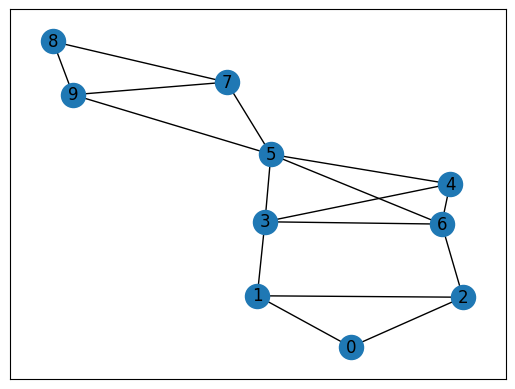

In [6]:
import matplotlib.pyplot as plt

nx.draw_networkx(inst_G, with_labels=True)
plt.show()

{0, 1, 2}, {3, 4, 5, 6}, {7, 8, 9}の3つのクリークから成るこのグラフが、実際にクリークに分けられるかを確認してみましょう。

### JijModeling transpilerによるPyQUBOへの変換

ここまで行われてきた実装は、全てJijModelingによるものでした。
これをPyQUBOに変換することで、OpenJijはもちろん、他のソルバーを用いた組合せ最適化計算を行うことが可能になります。

In [7]:
import jijmodeling_transpiler as jmt

# compile
compiled_model = jmt.core.compile_model(problem, instance_data, {})
# get qubo model
pubo_builder = jmt.core.pubo.transpile_to_pubo(compiled_model=compiled_model, relax_method=jmt.core.pubo.RelaxationMethod.AugmentedLagrangian)
qubo, const = pubo_builder.get_qubo_dict(multipliers={"color": 1.0})

### OpenJijによる求解

今回はOpenJijのシミュレーテッド・アニーリングを用いて、最適化問題を解いてみましょう。

In [8]:
import openjij as oj

# set sampler
sampler = oj.SASampler()
# solve problem
result = sampler.sample_qubo(qubo, num_reads=100)

`SASampler`を設定し、そのサンプラーに先程作成したQUBOモデルの`qubo`を入力することで、計算結果が得られます。また`num_reads`に正の整数を渡すことで、アニーリングのサンプリング数を指定することができます。

### デコードと解の表示

計算結果をデコードします。
また実行可能解の中から目的関数値が最小のものを選び出し、それを可視化してみましょう。

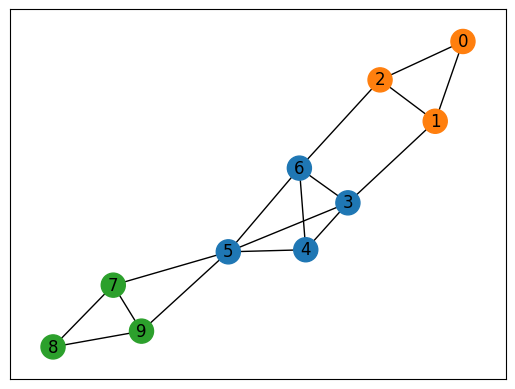

In [9]:
import numpy as np

# decode a result to JijModeling sampleset
sampleset = jmt.core.pubo.decode_from_openjij(result, pubo_builder, compiled_model)
feasible_samples = sampleset.feasible()
feasible_objectives = [objective for objective in feasible_samples.evaluation.objective]
if len(feasible_objectives) == 0:
    print("No feasible solution found ...")
else:
    lowest_index = np.argmin(feasible_objectives)
    x_indices = feasible_samples.record.solution["x"][lowest_index][0]
    node_colors = [-1] * instance_data["V"]
    cmap = plt.get_cmap("tab10")
    colors = [cmap(i) for i in range(instance_data["N"])]
    for pair in zip(*x_indices):
        node_colors[pair[0]] = colors[pair[1]]
    nx.draw_networkx(inst_G, node_color=node_colors, with_labels=True)
    plt.show()
    

予想通り、このグラフが3つのクリークに分けられていることがわかります。